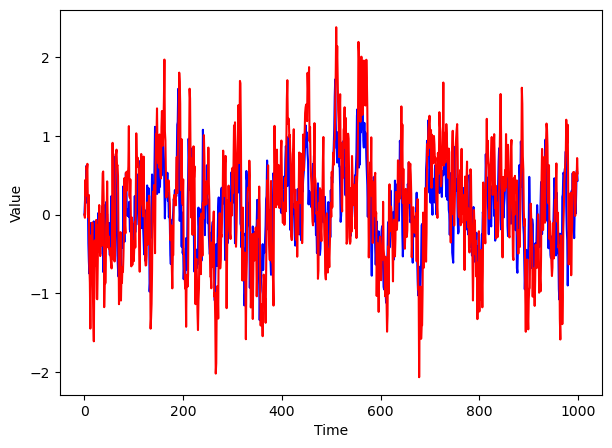

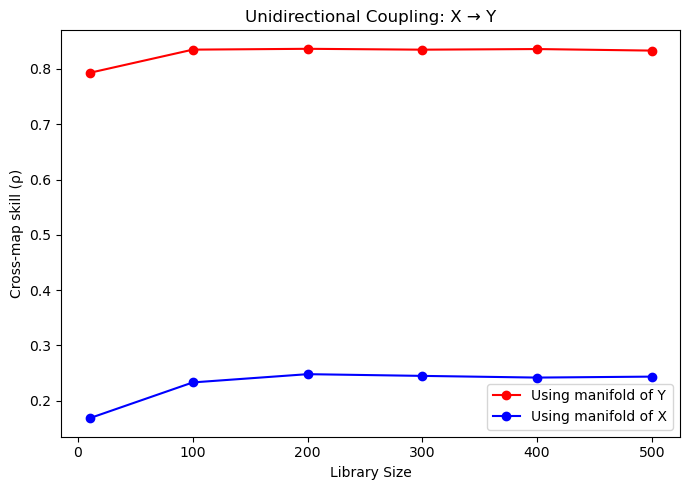

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------
# 1) Generate synthetic data
# ---------------------
N = 1000
np.random.seed(42)

X = np.zeros(N)
Y = np.zeros(N)

# Parameters for the unidirectional coupling: X -> Y
aX = 0.8   # How strongly X depends on its own past
aY = 0.4   # How strongly Y depends on its own past
cXY = 0.9  # Coupling strength: Y depends on X
noise_std = 0.3

# Initialize
X[0] = 0.0
Y[0] = 0.0

# Evolve the system
for t in range(1, N):
    # X is an AR(1) process
    X[t] = aX * X[t - 1] + noise_std * np.random.randn()
    # Y depends on Y[t-1] and also X[t-1]
    Y[t] = aY * Y[t - 1] + cXY * X[t - 2] + noise_std * np.random.randn()

# Create a time column for consistency
time = np.arange(N)

# Put into a DataFrame
df = pd.DataFrame({
    'time': time,
    'X': X,
    'Y': Y
})


# plot x and y
plt.figure(figsize=(7,5))
plt.plot(df['time'], df['X'], 'b-', label='X')
plt.plot(df['time'], df['Y'], 'r-', label='Y')
plt.xlabel('Time')
plt.ylabel('Value')

libSizes = "10 100 200 300 400 500"

# A) X->Y
ccm_out = CCM(
    dataFrame   = df,
    E           = 2,       # Embedding dimension
    tau         = 1,
    columns     = "Y",     # 'X' is the manifold (cause)
    target      = "X",     # 'Y' is the effect
    libSizes    = libSizes,
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = -2,       # Forecast horizon
    verbose     = False
)


plt.figure(figsize=(7,5))
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y')
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X')

plt.xlabel('Library Size')
plt.ylabel('Cross-map skill (ρ)')
plt.title('Unidirectional Coupling: X → Y')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# With a simple significant test

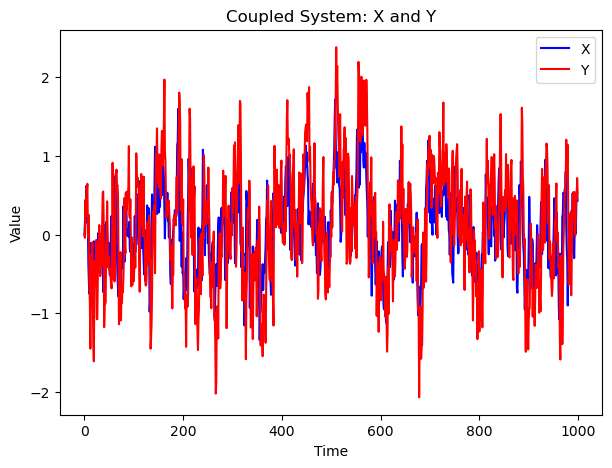

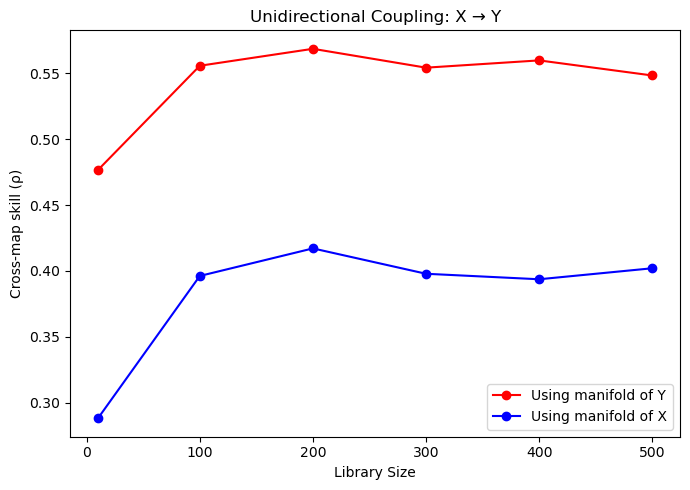

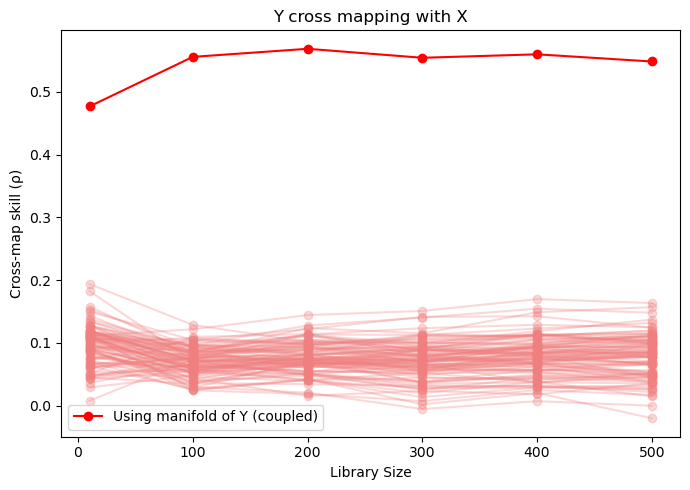

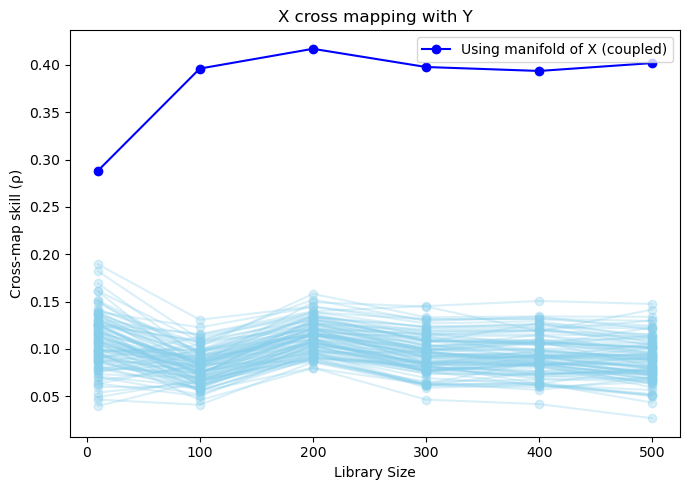

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------
# 1) Generate synthetic data for coupled system
# ---------------------
N = 1000
np.random.seed(42)

X = np.zeros(N)
Y = np.zeros(N)

# Parameters for the unidirectional coupling: X -> Y
aX = 0.8   # How strongly X depends on its own past
aY = 0.4   # How strongly Y depends on its own past
cXY = 0.9  # Coupling strength: Y depends on X
noise_std = 0.3

# Initialize
X[0] = 0.0
Y[0] = 0.0

# Evolve the system
for t in range(1, N):
    X[t] = aX * X[t - 1] + noise_std * np.random.randn()
    # Y is influenced by its own past and by X[t-2]
    Y[t] = aY * Y[t - 1] + cXY * X[t - 2] + noise_std * np.random.randn()

time = np.arange(N)

# Create DataFrame for coupled system
df = pd.DataFrame({
    'time': time,
    'X': X,
    'Y': Y
})

# Plot the coupled time series
plt.figure(figsize=(7,5))
plt.plot(df['time'], df['X'], 'b-', label='X')
plt.plot(df['time'], df['Y'], 'r-', label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title("Coupled System: X and Y")
plt.legend()
plt.show()

libSizes = "10 100 200 300 400 500"

# A) CCM: Using manifold of Y to predict X
ccm_out = CCM(
    dataFrame   = df,
    E           = 2,
    tau         = 1,
    columns     = "Y",      # Y is used as the manifold (cause)
    target      = "X",      # predicting X (effect)
    libSizes    = libSizes,
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = 0,       # Forecast horizon (negative for backward prediction)
    verbose     = False
)

plt.figure(figsize=(7,5))
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y')
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X')
plt.xlabel('Library Size')
plt.ylabel('Cross-map skill (ρ)')
plt.title('Unidirectional Coupling: X → Y')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------
# 2) Generate N=100 dummy Y series that do not contain X's signal
# ---------------------
n_dummy = 100
dummy_ccm_list = []

# Each dummy series is generated as an AR(1) process with parameter aY and noise,
# without any contribution from X.
for i in range(n_dummy):
    Y_dummy = np.zeros(N)
    Y_dummy[0] = 0.0
    for t in range(1, N):
        Y_dummy[t] = aY * Y_dummy[t - 1] + cXY * X[t - 2]+noise_std * np.random.randn()
    
    # divide the Y_dummy half and shift the position of two half
    Y_dummy = np.concatenate([Y_dummy[int(N/2):], Y_dummy[:int(N/2)]])


    # Create a DataFrame for CCM using the dummy Y (rename column as "Y_dummy")
    df_dummy = pd.DataFrame({
         'time': time,
         'X': X,
         'Y_dummy': Y_dummy
    })
    ccm_dummy_out = CCM(
         dataFrame   = df_dummy,
         E           = 2,
         tau         = 1,
         columns     = "Y_dummy",  # Use dummy Y as the manifold
         target      = "X",        # Predict X
         libSizes    = libSizes,
         sample      = 10,
         random      = True,
         replacement = False,
         Tp          = 0,
         verbose     = False
    )
    dummy_ccm_list.append(ccm_dummy_out)

# ---------------------
# 3) Plot CCM results, overlaying dummy curves as lighter curves
# ---------------------
plt.figure(figsize=(7,5))
# Plot dummy CCM curves in light color (e.g., light coral)
for ccm_dummy in dummy_ccm_list:
    plt.plot(ccm_dummy['LibSize'], ccm_dummy['Y_dummy:X'], 
             color='lightcoral', linestyle='-', marker='o', alpha=0.3)
# Plot the original CCM curve from the coupled system in a darker red
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y (coupled)')
plt.xlabel('Library Size')
plt.ylabel('Cross-map skill (ρ)')
plt.title('Y cross mapping with X')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
# Plot dummy CCM curves in light color (e.g., light coral)
for ccm_dummy in dummy_ccm_list:
    plt.plot(ccm_dummy['LibSize'], ccm_dummy['X:Y_dummy'], 
             color='skyblue', linestyle='-', marker='o', alpha=0.3)
# Plot the original CCM curve from the coupled system in a darker red
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X (coupled)')
plt.xlabel('Library Size')
plt.ylabel('Cross-map skill (ρ)')
plt.title('X cross mapping with Y')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


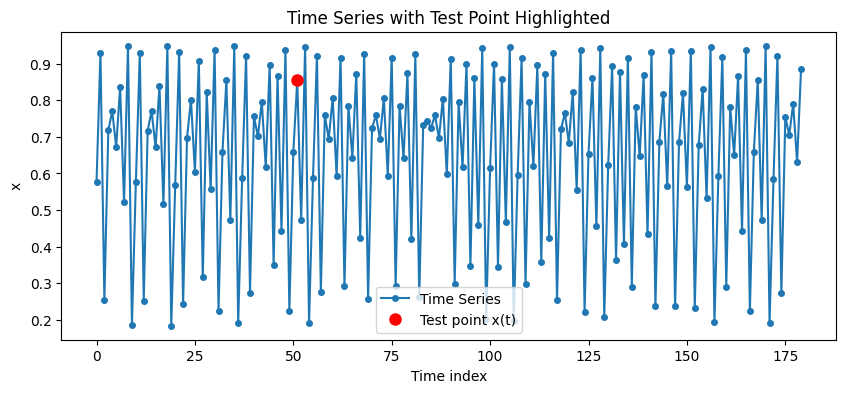

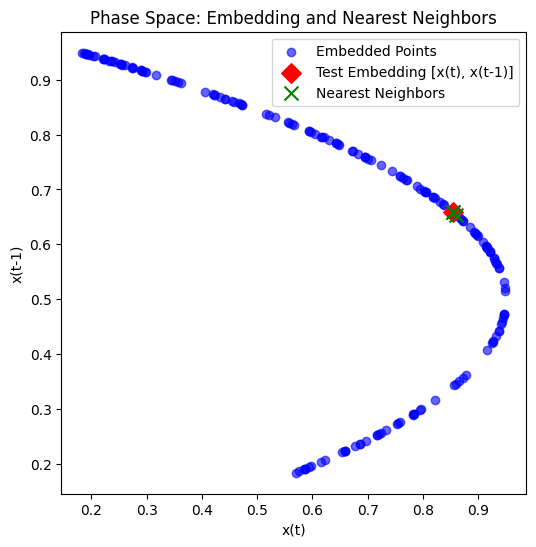

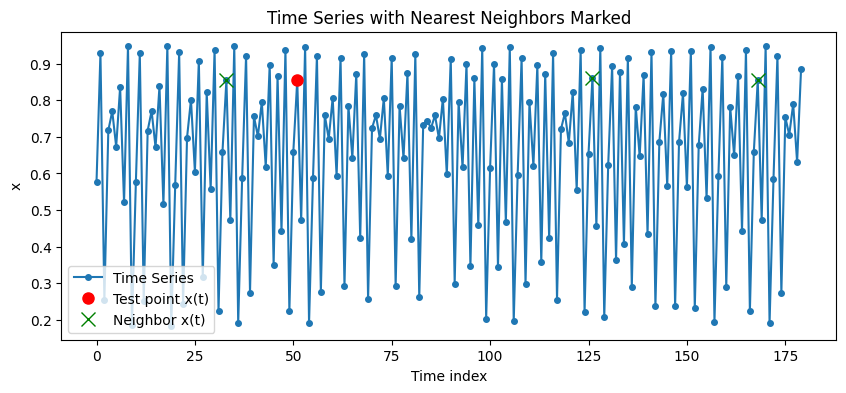

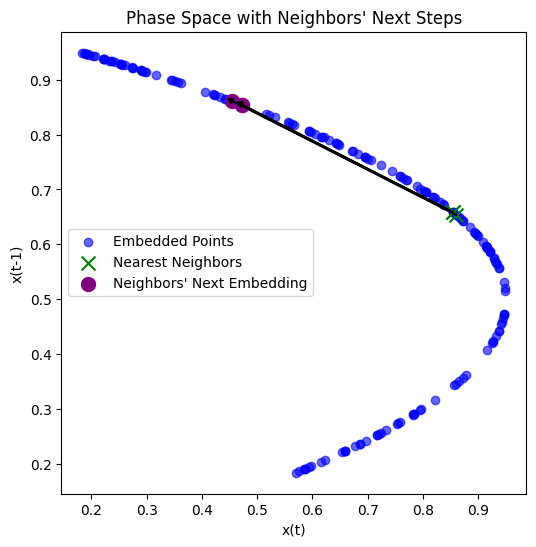

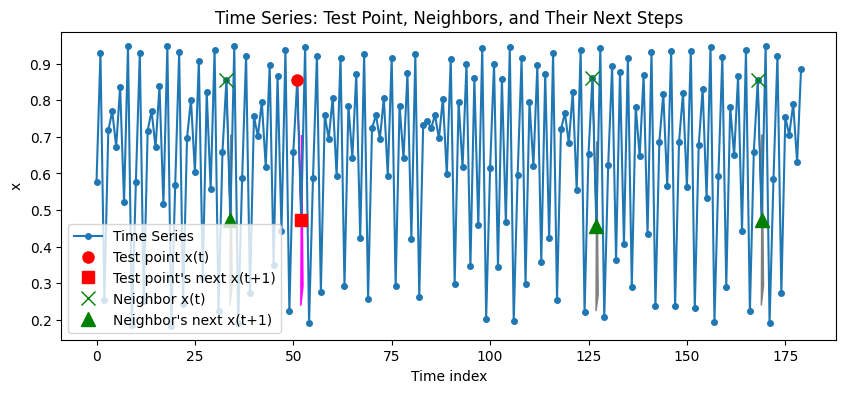

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Generate a time series X using the logistic map and plot it.
# -------------------------------

# Generate a chaotic time series using the logistic map.
N = 200
r = 3.8
x = np.zeros(N)
x[0] = 0.1
for t in range(1, N):
    x[t] = r * x[t-1] * (1 - x[t-1])

# Drop an initial transient for clarity.
transient = 20
x = x[transient:]
time = np.arange(len(x))

# Choose a test time (for predicting x(t+1)).
# The test point will be at time index t_test.
t_test = 51  # Ensure t_test >= 1 and t_test < len(x)-1

# Plot the time series and mark the test point.
plt.figure(figsize=(10, 4))
plt.plot(time, x, '-o', markersize=4, label='Time Series')
plt.plot(time[t_test], x[t_test], 'ro', markersize=8, label='Test point x(t)')
plt.xlabel('Time index')
plt.ylabel('x')
plt.title('Time Series with Test Point Highlighted')
plt.legend()
plt.show()

# -------------------------------
# 2. Time-Delay Embedding (E=2, tau=1) and Phase Space Plot with Nearest Neighbors
# -------------------------------

# Create embeddings: for t from 1 to len(x)-1,
# each embedding vector is [x(t), x(t-1)].
embeddings = np.column_stack((x[1:], x[:-1]))
embed_time = time[1:]  # corresponding time indices for embeddings

# The test embedding corresponds to the test point: [x(t_test), x(t_test-1)]
# which is at embedding index (t_test - 1)
test_embedding = embeddings[t_test - 1]

# Find the E+1 (=3) nearest neighbors to the test embedding in the phase space.
distances = np.linalg.norm(embeddings - test_embedding, axis=1)
# Exclude the test embedding itself by setting its distance to infinity.
distances[t_test - 1] = np.inf
k = 3
nn_indices = np.argsort(distances)[:k]

# Plot the phase space (embedding plot)
plt.figure(figsize=(6, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', label='Embedded Points', alpha=0.6)
plt.scatter(test_embedding[0], test_embedding[1], c='red', marker='D', s=100, label='Test Embedding [x(t), x(t-1)]')
plt.scatter(embeddings[nn_indices, 0], embeddings[nn_indices, 1], 
            c='green', marker='x', s=100, label='Nearest Neighbors')
plt.xlabel('x(t)')
plt.ylabel('x(t-1)')
plt.title('Phase Space: Embedding and Nearest Neighbors')
plt.legend()
plt.show()

# Also mark these neighbors on the original time series.
# Note: An embedding at index i corresponds to x(t) at time index i+1.
plt.figure(figsize=(10, 4))
plt.plot(time, x, '-o', markersize=4, label='Time Series')
plt.plot(time[t_test], x[t_test], 'ro', markersize=8, label='Test point x(t)')
for nn in nn_indices:
    plt.plot(time[nn+1], x[nn+1], 'gx', markersize=10, label='Neighbor x(t)' if nn==nn_indices[0] else "")
plt.xlabel('Time index')
plt.ylabel('x')
plt.title('Time Series with Nearest Neighbors Marked')
plt.legend()
plt.show()

# -------------------------------
# 3. Phase Space Plot with Neighbors' Next Steps
# -------------------------------

# For each neighbor (from the embedding at index nn), its "next step" is at time index (nn+2),
# and its next embedding (if available) is [x(nn+2), x(nn+1)].
next_embeddings = []
valid_nn = []  # store neighbor indices for which a next embedding exists
for nn in nn_indices:
    if nn + 2 < len(x):  # ensure we have x[nn+2]
        next_emb = np.array([x[nn+2], x[nn+1]])
        next_embeddings.append(next_emb)
        valid_nn.append(nn)
next_embeddings = np.array(next_embeddings)

plt.figure(figsize=(6, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', label='Embedded Points', alpha=0.6)
plt.scatter(embeddings[valid_nn, 0], embeddings[valid_nn, 1], 
            c='green', marker='x', s=100, label='Nearest Neighbors')
plt.scatter(next_embeddings[:, 0], next_embeddings[:, 1], 
            c='purple', marker='o', s=100, label="Neighbors' Next Embedding")
# Draw arrows from each neighbor to its next embedding.
for i, nn in enumerate(valid_nn):
    plt.arrow(embeddings[nn, 0], embeddings[nn, 1],
              next_embeddings[i, 0] - embeddings[nn, 0],
              next_embeddings[i, 1] - embeddings[nn, 1],
              head_width=0.01, head_length=0.01, fc='k', ec='k')
plt.xlabel('x(t)')
plt.ylabel('x(t-1)')
plt.title("Phase Space with Neighbors' Next Steps")
plt.legend()
plt.show()

# -------------------------------
# 4. Additional Time Series Plot: Show x(t), its Neighbors, and Their Next Steps
# -------------------------------

plt.figure(figsize=(10, 4))
plt.plot(time, x, '-o', markersize=4, label='Time Series')

# Mark the test point at t_test and its next step (forecast target: x(t_test+1)).
plt.plot(time[t_test], x[t_test], 'ro', markersize=8, label='Test point x(t)')
plt.plot(time[t_test+1], x[t_test+1], 'rs', markersize=8, label="Test point's next x(t+1)")

# For each neighbor (from embedding index nn, corresponding to time index nn+1):
#   - Mark neighbor's current x(t) value.
#   - Mark neighbor's next step x(t+1) at time index nn+2.
for i, nn in enumerate(nn_indices):
    curr_time = nn + 1  # neighbor's current time index
    next_time = nn + 2  # neighbor's next time index
    # Check that next_time is within bounds.
    if next_time < len(x):
        plt.plot(time[curr_time], x[curr_time], 'gx', markersize=10, label='Neighbor x(t)' if i==0 else "")
        plt.plot(time[next_time], x[next_time], 'g^', markersize=10, label="Neighbor's next x(t+1)" if i==0 else "")
        # Draw an arrow from neighbor's current point to its next step.
        plt.arrow(time[curr_time], x[curr_time],
                  time[next_time]-time[curr_time],
                  x[next_time]-x[curr_time],
                  head_width=0.5, head_length=0.5, fc='gray', ec='gray')
# Optionally, draw an arrow for the test point's evolution.
plt.arrow(time[t_test], x[t_test],
          time[t_test+1]-time[t_test],
          x[t_test+1]-x[t_test],
          head_width=0.5, head_length=0.5, fc='magenta', ec='magenta')

plt.xlabel('Time index')
plt.ylabel('x')
plt.title("Time Series: Test Point, Neighbors, and Their Next Steps")
plt.legend()
plt.show()


1000


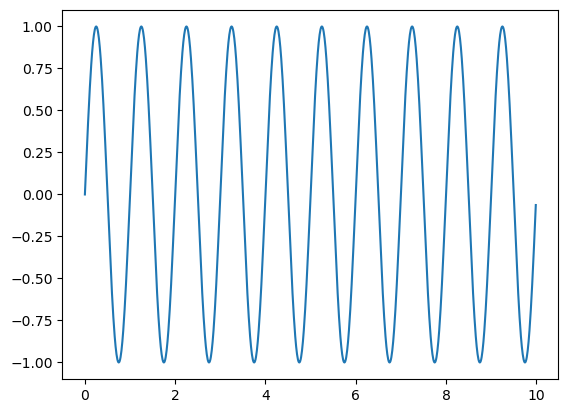

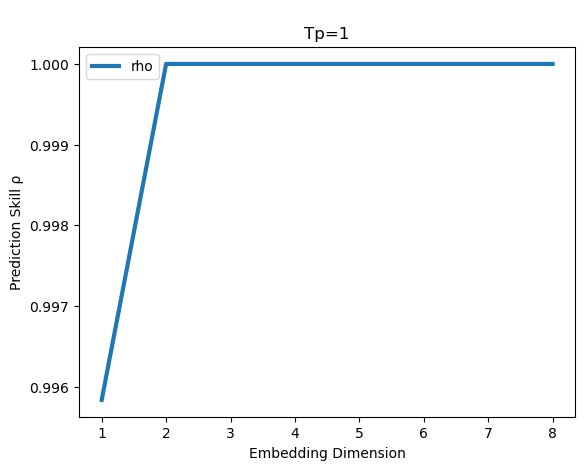

     E       rho
0  1.0  0.995836
1  2.0  1.000000
2  3.0  1.000000
3  4.0  1.000000
4  5.0  1.000000
5  6.0  1.000000
6  7.0  1.000000
7  8.0  1.000000


In [23]:
import numpy as np
import pandas as pd

# pyEDM is typically imported like so:
import pyEDM

# 1. Generate a synthetic sine wave time series
t = np.arange(0, 10, 0.01)   # 0 to 10, step 0.01
ts = np.sin(2 * np.pi * t)  # a basic sine wave

# print the length of the time series
print(len(ts))

# plot ts
import matplotlib.pyplot as plt
plt.plot(t, ts)

data = pd.DataFrame({"Time": t, "Sine": ts})


embedding_results = pyEDM.EmbedDimension(
    dataFrame = data,
    columns   = "Sine",
    target    = "Sine",
    lib       = "1 700",    # use first 700 points as 'library'
    pred      = "701 1000", # predict on the latter points
    maxE      = 8,
    tau = 10,
)

print(embedding_results)


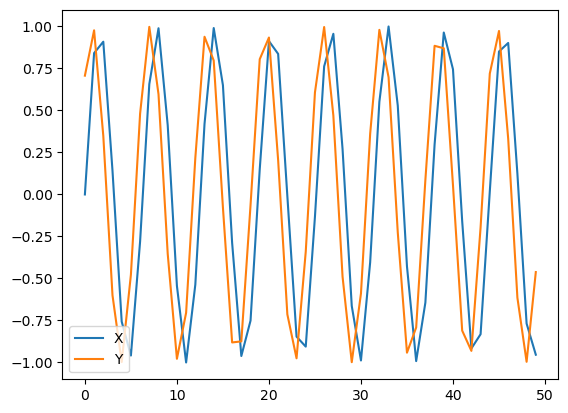

   LibSize       X:Y       Y:X
0     10.0  0.969423  0.911060
1     20.0  0.991039  0.985774
2     30.0  0.996326  0.993309
3     40.0  0.998102  0.997822
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


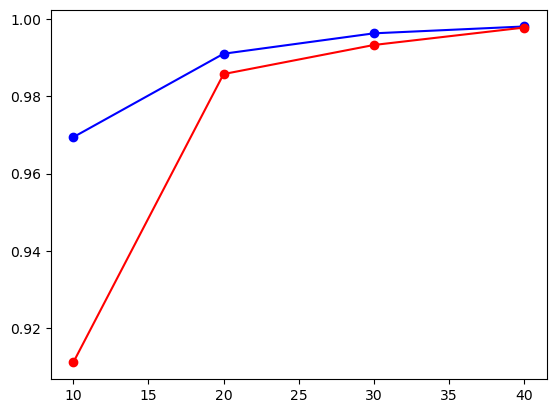

In [9]:
import pandas as pd
import numpy as np
from pyEDM import CCM

# Sample time series
t = np.arange(50)
x = np.sin(t)
y = np.sin(t + np.pi/4)

# plot the time series
import matplotlib.pyplot as plt
plt.plot(t, x, label='X')
plt.plot(t, y, label='Y')
plt.legend()
plt.show()

# Prepare DataFrame
df = pd.DataFrame({
    'Time': t,
    'X': x,
    'Y': y
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 2,
    tau         = 1,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "10 20 30 40",
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = 0
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-')



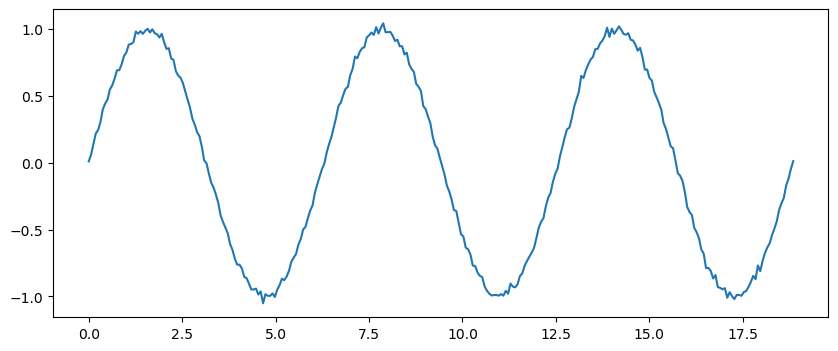

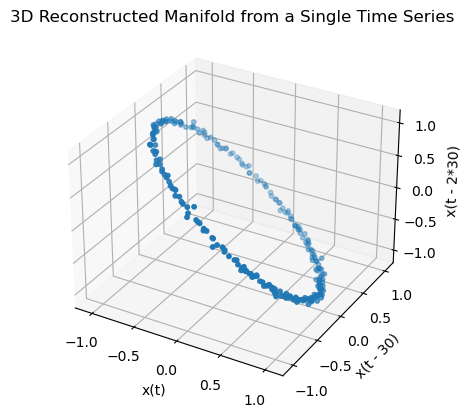

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate a univariate time series
#    Here we create a noisy sine wave for demonstration.
np.random.seed(42)  # For reproducibility
num_points = 300
time = np.linspace(0, 6*np.pi, num_points)  # 0 to 6π
true_signal = np.sin(time)
noise = 0.02 * np.random.randn(num_points)
x = true_signal + noise

# plot the time series
plt.figure(figsize=(10, 4))
plt.plot(time, x, label="Noisy Sine Wave")

# 2. Define parameters for Takens’ embedding
E = 3      # Embedding dimension
tau = 30    # Time lag

# 3. Construct the embedded manifold (shadow manifold)
#    X(t) = [ x(t), x(t - tau), x(t - 2*tau) ]
#    We'll skip the first (E-1)*tau points that can't form a full vector.
def takens_embedding(series, embedding_dimension, delay):
    """
    Returns the embedded (reconstructed) state-space from a given 1D time series.
    """
    N = len(series)
    # Number of valid embedded points
    M = N - (embedding_dimension - 1)*delay
    
    # Prepare an array for the embedded data
    embedded_data = np.zeros((M, embedding_dimension))
    for i in range(M):
        for e in range(embedding_dimension):
            embedded_data[i, e] = series[i + e*delay]
    return embedded_data

embedded = takens_embedding(x, E, tau)

# 4. Plot the manifold in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    embedded[:, 0],
    embedded[:, 1],
    embedded[:, 2],
    s=10  # marker size
)

ax.set_xlabel("x(t)")
ax.set_ylabel(f"x(t - {tau})")
ax.set_zlabel(f"x(t - 2*{tau})")
ax.set_title("3D Reconstructed Manifold from a Single Time Series")

plt.show()
